## 모든 모델 만든것 추가해서 Ensemble 
## 0과 1로 나온 결과만 넣고 평균 0.5 이상 -> 1
## 0.5 미만 -> 0

---

### 현재 모델 GM, BGM, LOF, AutoEncoder, Hotelling T2

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler

In [43]:
test = pd.read_csv('C:/Users/user/github/Data/aifactory/test_data.csv')
train = pd.read_csv('C:/Users/user/github/Data/aifactory/train_data.csv')


In [44]:
result = pd.DataFrame(index = test.index ,columns=['gm','bgm','hotelling','LOF','autoencoder'], data=0)

In [45]:
train = train.drop('out_pressure', axis=1)

In [46]:
test = test.drop('out_pressure',axis=1)

In [47]:
train_x_1 = train[(train['type']==0) | (train['type']==4)| (train['type']==5) | (train['type']==6) | (train['type']==7)]
train_x_2 = train[train['type'] == 1]
train_x_3 = train[train['type'] == 2]
train_x_4 = train[train['type'] == 3]

In [48]:
test_x_1 = test[(test['type']==0) | (test['type']==4)| (test['type']==5) | (test['type']==6) | (test['type']==7)]
test_x_2 = test[test['type'] == 1]
test_x_3 = test[test['type'] == 2]
test_x_4 = test[test['type'] == 3]

In [49]:
train_x_1 = train_x_1.drop('type', axis=1)
train_x_2 = train_x_2.drop('type', axis=1)
train_x_3 = train_x_3.drop('type', axis=1)
train_x_4 = train_x_4.drop('type', axis=1)

In [50]:
test_x_1 = test_x_1.drop('type', axis=1)
test_x_2 = test_x_2.drop('type', axis=1)
test_x_3 = test_x_3.drop('type', axis=1)
test_x_4 = test_x_4.drop('type', axis=1)

In [51]:
from sklearn.mixture import GaussianMixture

# GMM: n_components = 모델의 총 수
gm_1 = GaussianMixture(n_components=4, covariance_type = 'full',n_init=30, random_state=42)
gm_1.fit(train)

GaussianMixture(n_components=4, n_init=30, random_state=42)

In [52]:
from sklearn.mixture import BayesianGaussianMixture

bgm = BayesianGaussianMixture(n_components=4, n_init=15, random_state=42)
bgm.fit(train)
np.round(bgm.weights_, 2)

array([0.58, 0.29, 0.12, 0.01])

In [53]:
print(gm_1.converged_)
print(bgm.converged_)

True
True


In [54]:
densities = gm_1.score_samples(test)
density_threshold = np.percentile(densities, 2)

In [55]:
bgm_densities = bgm.score_samples(test)
bgm_density_threshold = np.percentile(bgm_densities, 2)

In [56]:
print(density_threshold)
print(bgm_density_threshold)

-146388.260813247
-1592.7521038903644


Text(0.5, 1.0, 'gmm result')

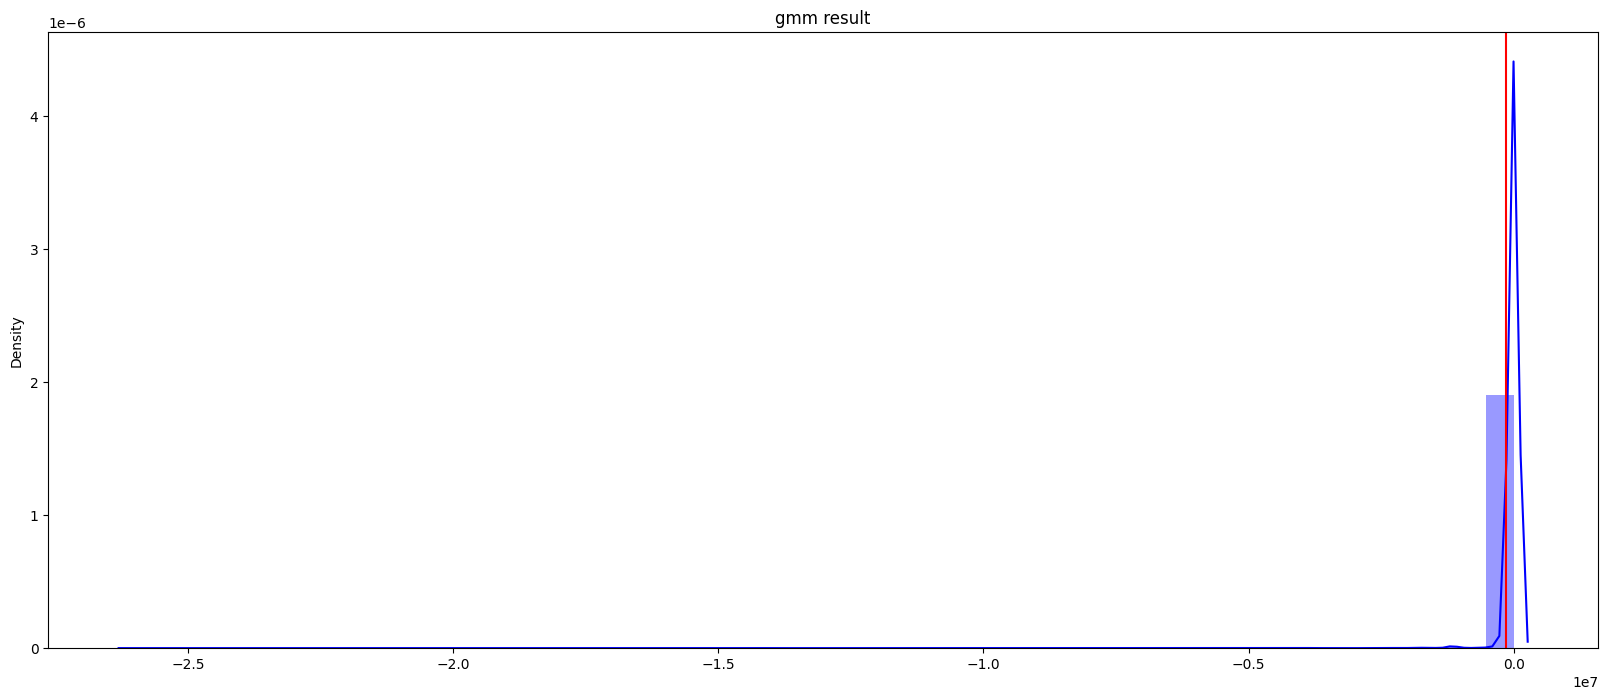

In [57]:
plt.figure(figsize=(20,8))
sns.distplot(densities, kde=True, color="b")
plt.axvline(density_threshold, color = 'red')
plt.title('gmm result')

Text(0.5, 1.0, 'bgm result')

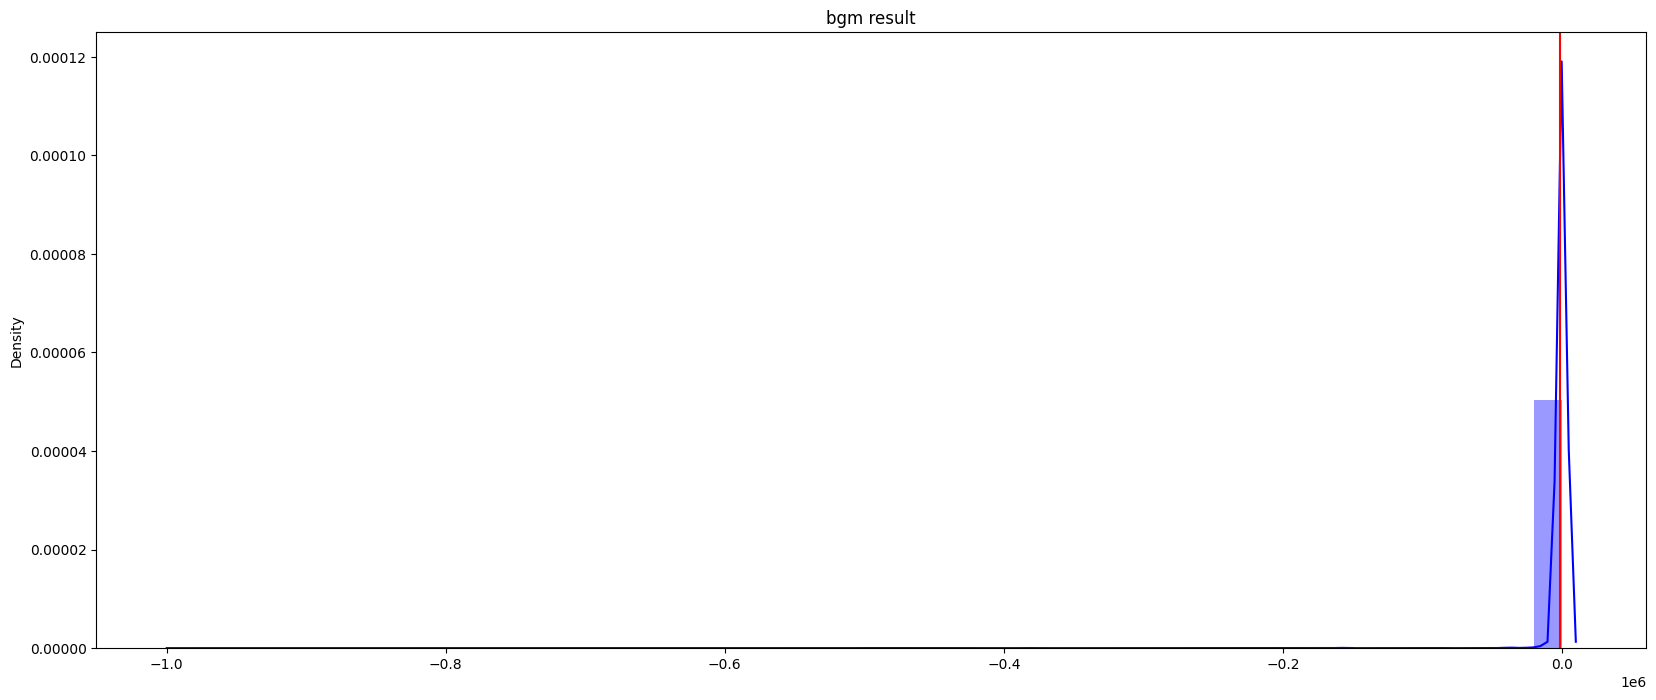

In [58]:
plt.figure(figsize=(20,8))
sns.distplot(bgm_densities, kde=True, color="b")
plt.axvline(bgm_density_threshold, color = 'red')
plt.title('bgm result')

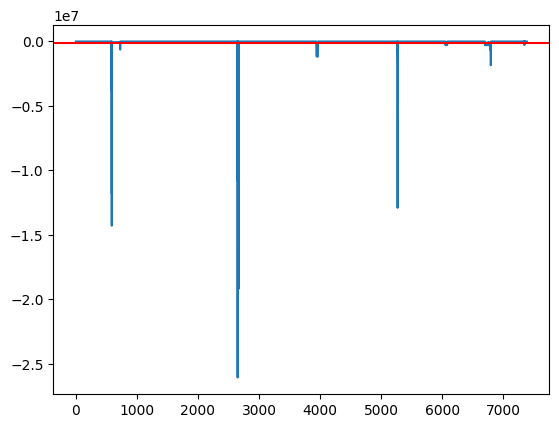

In [59]:
plt.plot(densities)
plt.axhline(density_threshold, color = 'r')
#plt.ylim(-90000,10)
plt.show()

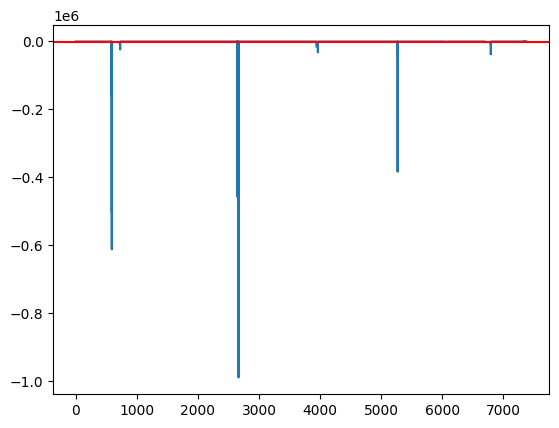

In [60]:
plt.plot(bgm_densities)
plt.axhline(bgm_density_threshold, color = 'r')
#plt.ylim(-2000,15)
plt.show()

In [61]:
anomalies = test[densities < density_threshold]

In [62]:
bgm_anomalies = test[bgm_densities < bgm_density_threshold]

In [63]:
anomalies

,air_inflow,air_end_temp,motor_current,motor_rpm,motor_temp,motor_vibe,type
586,2.06,51.95,31.64,2476.0,59.34,3.58,0
588,2.86,63.93,43.88,3434.0,61.34,4.11,0
590,2.89,64.34,44.30,3467.0,63.34,4.13,0
591,1.21,39.08,18.48,1446.0,64.34,3.00,0
717,2.51,60.91,40.64,3113.0,74.59,4.03,0
...,...,...,...,...,...,...,...
6798,1.83,57.98,34.44,2638.0,69.31,3.87,6
6799,1.99,60.84,37.43,2867.0,71.86,3.99,6
6800,1.44,50.90,27.05,2072.0,63.02,3.55,6
7348,2.76,62.36,42.28,3309.0,76.77,4.04,7


In [64]:
bgm_anomalies

,air_inflow,air_end_temp,motor_current,motor_rpm,motor_temp,motor_vibe,type
586,2.06,51.95,31.64,2476.0,59.34,3.58,0
587,1.35,41.20,20.65,1616.0,60.34,3.10,0
588,2.86,63.93,43.88,3434.0,61.34,4.11,0
590,2.89,64.34,44.30,3467.0,63.34,4.13,0
591,1.21,39.08,18.48,1446.0,64.34,3.00,0
...,...,...,...,...,...,...,...
6797,1.57,53.23,29.48,2258.0,65.09,3.65,6
6798,1.83,57.98,34.44,2638.0,69.31,3.87,6
6799,1.99,60.84,37.43,2867.0,71.86,3.99,6
6800,1.44,50.90,27.05,2072.0,63.02,3.55,6


In [65]:
result.loc[anomalies.index.tolist(), 'gm'] = 1
result.loc[bgm_anomalies.index.tolist(), 'bgm'] = 1

---

## Hotellings T2

In [66]:
import numpy as np

def hotellings_tsquare(trdat, tedat):
    '''
    Hotellings T-square : 공분산을 반영한 유클리디안 거리 (마할라노비스 거리)
    
    @param trdat : train data
    @param tedat : test data
    '''
    obs = trdat.shape[0]
    dim = trdat.shape[1]
    
    mu = trdat.apply(np.mean, axis=0) # 열단위 평균계산
    sinv = np.linalg.pinv(trdat.cov()) # 공분산 역행렬

    dte = (tedat-mu).values 
    
    Tsq_mat = np.zeros(tedat.shape[0])
    for i in range(tedat.shape[0]):
        Tsq_mat[i] = dte[i,:] @ sinv @ dte[i,:].transpose() # t-square distance
        
    return Tsq_mat

def bootstrap_limit(stat, alpha=0.05, bootstrap=100):
    '''
    Bootstrap sampling을 활용한 Control Limit 산출 기법
    
    @param stat : 통계량
    @param alpha : Control Limit을 정하기 위한 유의수준
    @param : bootstrap : 샘플링 횟수
    '''
    alpha = (alpha/2)*100
    alpha = 100 - alpha
    samsize = max(10000, len(stat))
    limit = np.mean(list(map(lambda x:np.percentile(np.random.choice(stat,samsize,replace=True),alpha), range(0,bootstrap))))
    # stat에서 samsize만큼 선택 후 75%분위수(alpha에따라 변경) 뽑기 이후 bootstrap만큼 반복 후 리스트로 만들고 평균 계산
    return limit

In [67]:
hotellings_1 = hotellings_tsquare(pd.DataFrame(test_x_1), pd.DataFrame(train_x_1))
hotellings_2 = hotellings_tsquare(pd.DataFrame(train_x_2), pd.DataFrame(train_x_2))
hotellings_3 = hotellings_tsquare(pd.DataFrame(train_x_3), pd.DataFrame(train_x_3))
hotellings_4 = hotellings_tsquare(pd.DataFrame(train_x_4), pd.DataFrame(train_x_4))


In [68]:
hotellings_1_all = hotellings_tsquare(pd.DataFrame(train_x_1), pd.DataFrame(test_x_1))
hotellings_2_all = hotellings_tsquare(pd.DataFrame(train_x_2), pd.DataFrame(test_x_2))
hotellings_3_all = hotellings_tsquare(pd.DataFrame(train_x_3), pd.DataFrame(test_x_3))
hotellings_4_all = hotellings_tsquare(pd.DataFrame(train_x_4), pd.DataFrame(test_x_4))


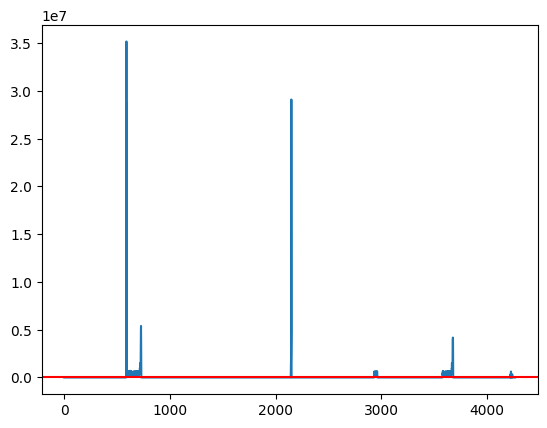

In [69]:
plt.plot(hotellings_1_all)
plt.axhline(y = bootstrap_limit(hotellings_1), color = 'r')
plt.show()

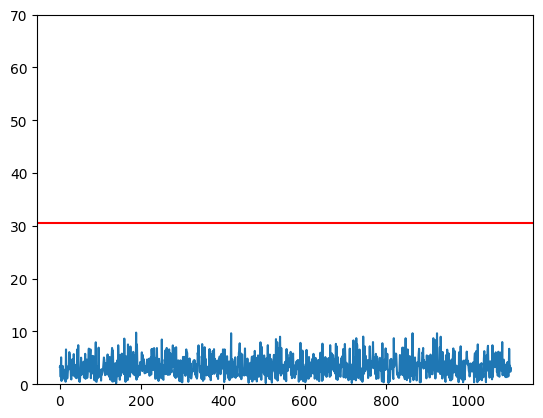

In [70]:
plt.plot(hotellings_2_all)
plt.axhline(y = bootstrap_limit(hotellings_2), color = 'r')
plt.ylim(0,70)
plt.show()

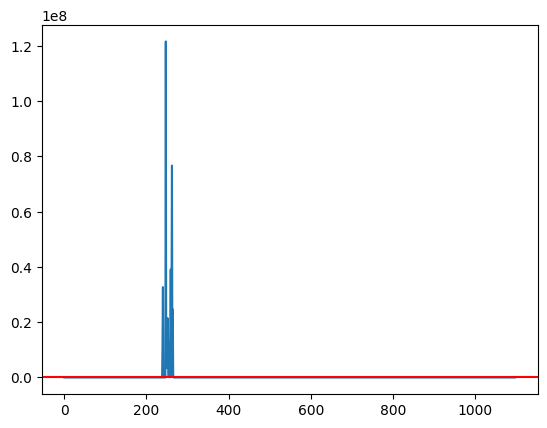

In [71]:
plt.plot(hotellings_3_all)
plt.axhline(y = bootstrap_limit(hotellings_3), color = 'r')
plt.show()

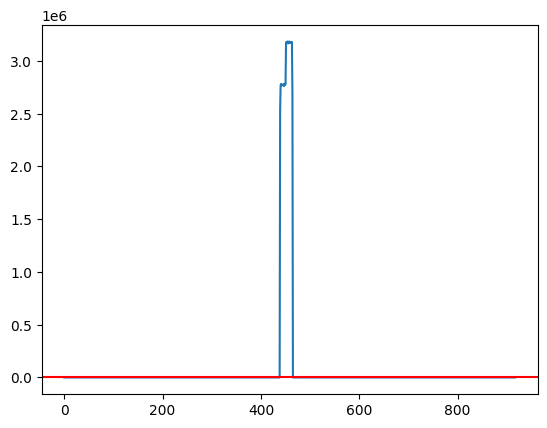

In [72]:
plt.plot(hotellings_4_all)
plt.axhline(y = bootstrap_limit(hotellings_4), color = 'r')
plt.show()

In [73]:
hotellings_1_anomalies = test_x_1[hotellings_1_all > bootstrap_limit(hotellings_1)]
hotellings_2_anomalies = test_x_2[hotellings_2_all > bootstrap_limit(hotellings_2)]
hotellings_3_anomalies = test_x_3[hotellings_3_all > bootstrap_limit(hotellings_3)]
hotellings_4_anomalies = test_x_4[hotellings_4_all > bootstrap_limit(hotellings_4)]

In [74]:
result.loc[hotellings_1_anomalies.index.tolist(), 'hotelling'] = 1
result.loc[hotellings_2_anomalies.index.tolist(), 'hotelling'] = 1
result.loc[hotellings_3_anomalies.index.tolist(), 'hotelling'] = 1
result.loc[hotellings_4_anomalies.index.tolist(), 'hotelling'] = 1

---

## LOF

In [75]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import GridSearchCV

In [76]:
clf = LocalOutlierFactor(n_neighbors=10, contamination=0.5)

In [77]:
param_grid = {'n_neighbors' : [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28], 'contamination' : [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],}

In [78]:
clf = LocalOutlierFactor()

In [79]:
grid_search = GridSearchCV(estimator=clf, 
                           param_grid=param_grid,
                           scoring='accuracy', 
                           n_jobs=-1, 
                           verbose=2
                          )

In [80]:
grid_search.fit(train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(estimator=LocalOutlierFactor(), n_jobs=-1,
             param_grid={'contamination': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,
                                           0.8, 0.9],
                         'n_neighbors': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
                                         16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
                                         26, 27, 28]},
             scoring='accuracy', verbose=2)

In [81]:
grid_search.best_params_

{'contamination': 0.1, 'n_neighbors': 5}

In [82]:
clf2 = LocalOutlierFactor(n_neighbors=5, contamination=0.1)

In [83]:
clf2.fit(train)

LocalOutlierFactor(contamination=0.1, n_neighbors=5)

In [84]:
clf2.fit_predict(test)

array([-1,  1,  1, ...,  1,  1,  1])

In [85]:
lof_score = clf2.negative_outlier_factor_

In [86]:
lof_threshold = np.percentile(lof_score, 5)

(-6.0, 0.5)

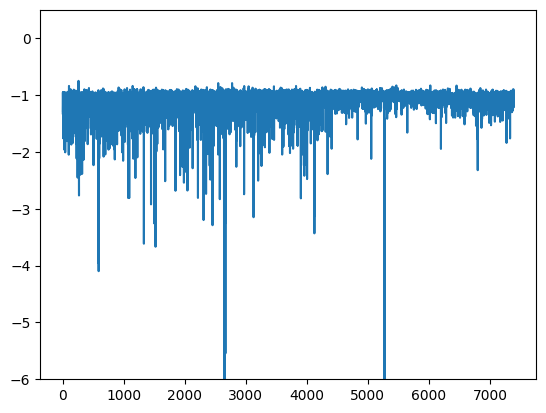

In [88]:
plt.plot(lof_score)
plt.ylim(-6,0.5)

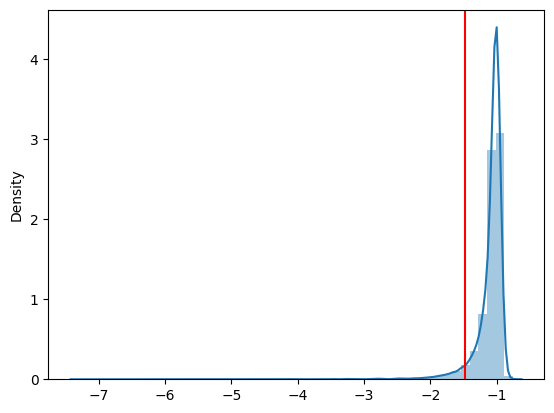

In [90]:
sns.distplot(lof_score)
plt.axvline(lof_threshold, color = 'r')
plt.show()

In [92]:
np.where(lof_score<lof_threshold)[0]

array([   6,   18,   23,   27,   40,   67,   69,   80,   84,   97,   98,
        121,  124,  140,  147,  164,  165,  167,  171,  173,  195,  210,
        220,  227,  230,  236,  243,  246,  256,  265,  266,  283,  287,
        297,  304,  305,  314,  317,  322,  327,  336,  339,  340,  357,
        359,  384,  408,  413,  459,  462,  473,  489,  504,  506,  517,
        550,  555,  562,  565,  586,  587,  588,  590,  591,  597,  599,
        632,  669,  675,  676,  677,  683,  688,  697,  709,  712,  715,
        724,  725,  743,  750,  768,  789,  794,  805,  811,  813,  819,
        824,  830,  831,  832,  837,  842,  852,  874,  877,  879,  890,
        898,  905,  914,  963,  971,  972,  973,  977,  978,  980,  985,
        989,  991, 1011, 1012, 1018, 1020, 1025, 1033, 1068, 1072, 1073,
       1077, 1089, 1093, 1106, 1112, 1118, 1132, 1137, 1138, 1140, 1142,
       1156, 1158, 1162, 1171, 1183, 1190, 1222, 1229, 1236, 1260, 1265,
       1269, 1270, 1312, 1329, 1335, 1342, 1356, 13

In [94]:
result.loc[np.where(lof_score<lof_threshold)[0], 'LOF'] = 1

---

## AutoEncoder

In [95]:
scaler = StandardScaler()

In [96]:
train = scaler.fit_transform(train)

In [97]:
test = scaler.fit_transform(test)

In [98]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

In [99]:
input_dim = train.shape[1]

input_layer = Input(shape=(input_dim,))
encoder = Dense(8, activation='relu')(input_layer)
decoder = Dense(input_dim, activation='sigmoid')(encoder)

autoencoder = Model(input_layer, decoder)
autoencoder.compile(optimizer='adam', loss='mse')


In [100]:
autoencoder.fit(train, train, epochs=100, batch_size=50, shuffle=True)

Epoch 1/100
50/50 [==============================] - 0s 572us/step - loss: 1.1897
Epoch 2/100
50/50 [==============================] - 0s 510us/step - loss: 1.1089
Epoch 3/100
50/50 [==============================] - 0s 510us/step - loss: 1.0159
Epoch 4/100
50/50 [==============================] - 0s 535us/step - loss: 0.9229
Epoch 5/100
50/50 [==============================] - 0s 528us/step - loss: 0.8442
Epoch 6/100
50/50 [==============================] - 0s 500us/step - loss: 0.7839
Epoch 7/100
50/50 [==============================] - 0s 521us/step - loss: 0.7421
Epoch 8/100
50/50 [==============================] - 0s 519us/step - loss: 0.7131
Epoch 9/100
50/50 [==============================] - 0s 510us/step - loss: 0.6914
Epoch 10/100
50/50 [==============================] - 0s 513us/step - loss: 0.6746
Epoch 11/100
50/50 [==============================] - 0s 674us/step - loss: 0.6619
Epoch 12/100
50/50 [==============================] - 0s 531us/step - loss: 0.6521
Epoch 13/100


In [101]:
x_pred = autoencoder.predict(test)
mse = np.mean(np.power(test - x_pred, 2), axis=1)

231/231 [==============================] - 0s 442us/step


In [103]:
# 이상치 검출
auto_threshold = np.mean(mse) + 3*np.std(mse)
auto_outliers = np.where(mse > auto_threshold)[0]

In [104]:
auto_threshold

2.299791531091828

In [106]:
auto_outliers

array([2406, 2413, 2416, 2418, 2420, 2425, 2428, 2429, 2430, 2455, 2457,
       2464, 2468, 2478, 2479, 2488, 2492, 2509, 2510, 2517, 2518, 2529,
       2536, 2541, 2560, 2573, 2575, 2594, 2612, 2619, 2622, 2624, 2637,
       2668, 2683, 2691, 2697, 2699, 2701, 2715, 2716, 2724, 2735, 2736,
       2739, 2745, 2750, 2753, 2758, 2764, 2768, 2781, 2782, 2793, 2797,
       2802, 2805, 2806, 2810, 2813, 2816, 2817, 2825, 2836, 2847, 2853,
       2862, 2873, 2879, 2887, 2888, 2889, 2895, 2913, 2915, 2918, 2935,
       2940, 2941, 2946, 2972, 2980, 2986, 2987, 3007, 3086, 3088, 3094,
       3109, 3110, 3112, 3142, 3143, 3154, 3155, 3170, 3182, 3185, 3198,
       3211, 3225, 3258, 3269, 3282, 3299, 3316, 3322, 3341, 3368, 3396,
       3400, 3407, 3416, 3417, 3431, 3500, 3507, 3529, 3542, 3559, 3572,
       3605, 3616, 3625, 3636, 3647, 3648, 3654, 3706, 3710, 3748, 3757,
       3822, 3858, 3866, 3867, 3871, 3880, 3888, 3896, 3897, 3935, 3942,
       3950, 3955, 3958, 3960, 4061, 4109, 4195, 42

In [108]:
result.loc[auto_outliers, 'autoencoder'] = 1

In [109]:
result['label'] = result.mean(axis=1)

In [110]:
for i in range(len(result)):
    if result.label[i] > 0.5:
        result.label[i] = 1
    else:
        result.label[i] = 0

<Axes: >

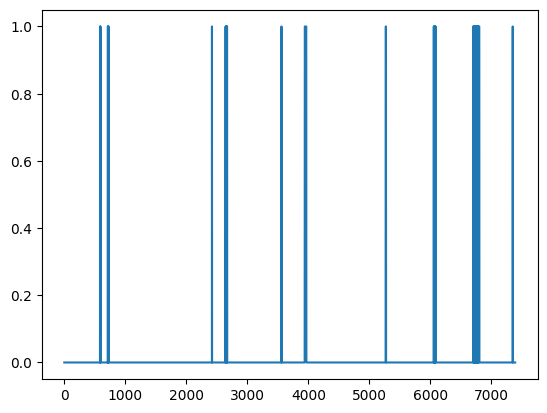

In [111]:
result.label.plot()

result.to_csv('C:/Users/user/Desktop/result.csv', index=False)

In [113]:
result.label.value_counts()

0.0    7282
1.0     107
Name: label, dtype: int64